<CENTER><img src="../../images/ATLASOD.gif" style="width:50%"></CENTER>

# Search for the Graviton yourself!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to search for the Graviton yourself!

ATLAS Open Data provides open access to proton-proton collision data at the LHC for educational purposes. ATLAS Open Data resources are ideal for high-school, undergraduate and postgraduate students.

Notebooks are web applications that allow you to create and share documents that can contain for example:
1. live code
2. visualisations
3. narrative text

The idea is that cuts increase the ratio of signal (Graviton) to background ($Z, t\bar{t}, t\bar{t}V, ZZ$)

This analysis loosely follows the search for a ZZ resonance by ATLAS https://link.springer.com/article/10.1140%2Fepjc%2Fs10052-018-5686-3 (mostly Figure 4)

By the end of this notebook you will be able to:
1. search for the Graviton yourself!
2. know some general principles of a particle physics search

Feynman diagram pictures are borrowed from our friends at https://www.particlezoo.net

<CENTER><img src="images/feynman_diagrams/Graviton_feynman.png" style="width:40%"></CENTER>

<a id='contents'></a>

Contents: 

[Running a Jupyter notebook](#running) <br />
[First time setup on your computer (no need on mybinder)](#setup_computer) <br />
[To setup everytime](#setup_everytime) <br />
[Lumi, fraction, file path](#fraction) <br />
[Samples](#samples) <br />
[Changing a cut](#changing_cut) <br />
[Applying a cut](#applying_cut) <br />
[Plotting](#plotting) <br />
[What can you do to explore this analysis?](#going_further) <br />

<a id='running'></a>

## Running a Jupyter notebook

To run the whole Jupyter notebook, in the top menu click Cell -> Run All.

To propagate a change you've made to a piece of code, click Cell -> Run All Below.

You can also run a single code cell, by clicking Cell -> Run Cells, or using the keyboard shortcut Shift+Enter.

<a id='setup_computer'></a>

## First time setup on your computer (no need on mybinder)
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If you open on mybinder, you don't need to run this cell.

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip
!{sys.executable} -m pip install -U numpy pandas uproot3 matplotlib --user

[Back to contents](#contents)

<a id='setup_everytime'></a>

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in python
* pandas: lets us store data as dataframes, a format widely used in python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [1]:
import uproot3 # for reading .root files
import pandas as pd # to store data as dataframe
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator,LogLocator,LogFormatterSciNotation # for minor ticks

import infofile # local file containing cross-sections, sums of weights, dataset IDs

[Back to contents](#contents)

<a id='fraction'></a>

## Lumi, fraction, file path

General definitions of luminosity, fraction of data used, where to access the input files

In [2]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 0.09 # reduce this is you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address


[Back to contents](#contents)

<a id='samples'></a>

## Samples

samples to process

In [3]:
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D']
    },
    
    r'$Z,t\bar{t}$' : { # Z + ttbar
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#6b59d3" # purple
    },
    
    r'$t\bar{t}V$' : { # ttV
        'list' : ['ttW','ttee','ttmumu'], # ttW, ttZ(->ee), ttZ(->mm)
        'color' : "#f0f423" # yellow
    },
    
    'ZZ' : { # ZZ->llll
        'list' : ['llll'],
        'color' : "#ff0000" # red
    },
    
    'Graviton' : {
        'list' : ['RS_G_ZZ_llll_c10_m0500'], # mG = 500 GeV
        'color' : "#baff8d" # green
    },

}

[Back to contents](#contents)

Define function to get data from files

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

In [4]:
def get_data_from_files():

    data = {} # define empty dictionary to hold dataframes
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append dataframe returned from read_file to list of dataframes
        data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes
    
    return data # return dictionary of dataframes

[Back to contents](#contents)

define function to calculate weight of MC event

In [5]:
def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return xsec_weight*mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER

define function to get cross-section weight

In [6]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

define function to calculate 4-lepton invariant mass

In [7]:
def calc_mllll(lep_pt,lep_eta,lep_phi,lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*math.cos(lep_phi[0]) # x-component of lep[0] momentum
    py_0 = lep_pt[0]*math.sin(lep_phi[0]) # y-component of lep[0] momentum
    pz_0 = lep_pt[0]*math.sinh(lep_eta[0]) # z-component of lep[0] momentum
    px_1 = lep_pt[1]*math.cos(lep_phi[1]) # x-component of lep[1] momentum
    py_1 = lep_pt[1]*math.sin(lep_phi[1]) # y-component of lep[1] momentum
    pz_1 = lep_pt[1]*math.sinh(lep_eta[1]) # z-component of lep[1] momentum
    px_2 = lep_pt[2]*math.cos(lep_phi[2]) # x-component of lep[2] momentum
    py_2 = lep_pt[2]*math.sin(lep_phi[2]) # y-component of lep[2] momentum
    pz_2 = lep_pt[2]*math.sinh(lep_eta[2]) # z-component of lep[3] momentum
    px_3 = lep_pt[3]*math.cos(lep_phi[3]) # x-component of lep[3] momentum
    py_3 = lep_pt[3]*math.sin(lep_phi[3]) # y-component of lep[3] momentum
    pz_3 = lep_pt[3]*math.sinh(lep_eta[3]) # z-component of lep[3] momentum
    sumpx = px_0 + px_1 + px_2 + px_3 # x-component of 4-lepton momentum
    sumpy = py_0 + py_1 + py_2 + py_3 # y-component of 4-lepton momentum
    sumpz = pz_0 + pz_1 + pz_2 + pz_3 # z-component of 4-lepton momentum
    sumE = lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3] # energy of 4-lepton system
    return math.sqrt(sumE**2 - sumpx**2 - sumpy**2 - sumpz**2)/1000 #/1000 to go from MeV to GeV

[Back to contents](#contents)

<a id='changing_cut'></a>

## Changing a cut

If you change a cut: Cell -> Run All Below

If you change a cut here, you also need to make sure the cut is applied in the "[Applying a cut](#applying_cut)" cell.

In [8]:
# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton is [0], 2nd lepton is [1] etc
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (sum_lep_type != 44) and (sum_lep_type != 48) and (sum_lep_type != 52)

[Back to contents](#contents)

<a id='applying_cut'></a>

## Applying a cut
If you add a cut: Cell -> Run All Below

In [9]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot3.open(path)["mini"] # open the tree called mini
    numevents = uproot3.numentries(path, "mini") # number of events
    if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
    for data in tree.iterate(['lep_pt','lep_eta','lep_phi',
                              'lep_E','lep_charge','lep_type', 
                              # add more variables here if you make cuts on them 
                              'mcWeight','scaleFactor_PILEUP',
                              'scaleFactor_ELE','scaleFactor_MUON',
                              'scaleFactor_LepTRIGGER'], # variables to calculate Monte Carlo weight
                             outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                             entrystop=numevents*fraction): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch

        if 'data' not in sample: # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
            data['totalWeight'] = np.vectorize(calc_weight)(xsec_weight,
                                                            data.mcWeight,
                                                            data.scaleFactor_PILEUP,
                                                            data.scaleFactor_ELE,
                                                            data.scaleFactor_MUON,
                                                            data.scaleFactor_LepTRIGGER)

        # cut on lepton charge using the function cut_lep_charge defined above
        fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index
        data.drop(fail, inplace=True)

        # cut on lepton type using the function cut_lep_type defined above
        fail = data[ np.vectorize(cut_lep_type)(data.lep_type) ].index
        data.drop(fail, inplace=True)

        # calculation of 4-lepton invariant mass using the function calc_mllll defined above
        data['mllll'] = np.vectorize(calc_mllll)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
        
        # dataframe contents can be printed at any stage like this
        #print(data)

        # dataframe column can be printed at any stage like this
        #print(data['lep_pt'])

        # multiple dataframe columns can be printed at any stage like this
        #print(data[['lep_pt','lep_eta']])

        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample
        elapsed = time.time() - start # time taken to process
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return data_all # return dataframe containing events passing all cuts

[Back to contents](#contents)

This is where the processing happens (this will take some minutes)

In [10]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing data samples
	Processing: data_A
		 nIn: 3,	 nOut: 	2	 in 1.3s
	Processing: data_B
		 nIn: 14,	 nOut: 	8	 in 2.4s
	Processing: data_C
		 nIn: 21,	 nOut: 	12	 in 2.1s
	Processing: data_D
		 nIn: 36,	 nOut: 	17	 in 4.5s
Processing $Z,t\bar{t}$ samples
	Processing: Zee
		 nIn: 80,	 nOut: 	17	 in 5.9s
	Processing: Zmumu
		 nIn: 61,	 nOut: 	26	 in 6.4s
	Processing: ttbar_lep
		 nIn: 92,	 nOut: 	28	 in 13.9s
Processing $t\bar{t}V$ samples
	Processing: ttW
		 nIn: 123,	 nOut: 	27	 in 16.0s
	Processing: ttee
		 nIn: 2888,	 nOut: 	1285	 in 140.1s
	Processing: ttmumu
		 nIn: 2397,	 nOut: 	983	 in 103.1s
Processing ZZ samples
	Processing: llll
		 nIn: 49885,	 nOut: 	47162	 in 154.9s
Processing Graviton samples
	Processing: RS_G_ZZ_llll_c10_m0500
		 nIn: 584,	 nOut: 	538	 in 8.6s
Time taken: 459.1s


[Back to contents](#contents)

<a id='plotting'></a>

## Plotting
If you only want a make a change in plotting: Cell -> Run All Below

Define class to display log values

In [11]:
# define class to display 1 and 10 normally
class CustomTicker(LogFormatterSciNotation): 
    def __call__(self, x, pos=None): 
        if x not in [1,10]: # not 1 or 10
            return LogFormatterSciNotation.__call__(self,x, pos=None)
        else: # 1 or 10
            return "{x:g}".format(x=x) # standard notation

Define function to plot the data

In [12]:
def plot_data(data):

    xmin = 130 # GeV
    xmax = 1230 # GeV
    step_size = 55 # GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['mllll'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = data['Graviton']['mllll'] # histogram the signal
    signal_weights = data['Graviton'].totalWeight # get the weights of the signal events
    signal_color = samples['Graviton']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', 'Graviton']: # if not data nor signal
            mc_x.append( data[s]['mllll'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    mc_x_err = np.sqrt( mc_x_tot ) # statistical error on the MC bars
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label='Graviton')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    main_axes.set_yscale('log') # set y-scale
    smallest_contribution = mc_heights[0][0] # get smallest contribution
    smallest_contribution.sort() # sort smallest contribution
    bottom = np.amax(data_x)/1000 # set bottom limit on y-axis
    top = np.amax(data_x)*100 # set top limit on y-axis
    main_axes.set_ylim( bottom=bottom, top=top ) # y-axis limits
    main_axes.yaxis.set_major_formatter( CustomTicker() ) 
    locmin = LogLocator(base=10.0, # log base 10
                        subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9) ) # minor tick every 0.1 
    main_axes.yaxis.set_minor_locator( locmin ) # set minor ticks

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(round(lumi*fraction,2)) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV, '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.75, # y
             r'$G \rightarrow ZZ \rightarrow l^+l^-l^+l^-$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend(ncol=2, # 2 columns
                     frameon=False ) # no box around the legend
    
    return

[Back to contents](#contents)

Call the function to plot the data

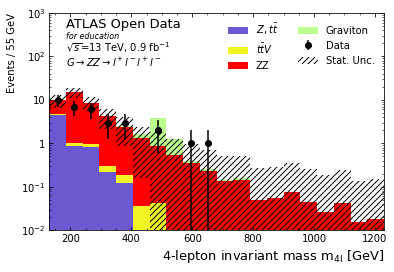

In [13]:
plot_data(data)

[Back to contents](#contents)

<a id='going_further'></a>

## What can you do to explore this analysis?

* Increase the fraction of data used in '[Lumi, fraction, file path](#fraction)'
* Check how many events are being thrown away by each cut in '[Applying a cut](#applying_cut)'
* Add more cuts from the [ATLAS paper searching for ZZ resonances](https://link.springer.com/article/10.1140%2Fepjc%2Fs10052-018-5686-3#Sec5) in '[Changing a cut](#changing_cut)' and '[Applying a cut](#applying_cut)'
* Add a plot to show the ratio between Data and MC other than Graviton like [Figure 4 of the ATLAS paper searching for ZZ resonances](https://link.springer.com/article/10.1140%2Fepjc%2Fs10052-018-5686-3#Fig4)
* Get the estimated numbers of events, similar to [Table 4 of the ATLAS paper searching for ZZ resonances](https://link.springer.com/article/10.1140/epjc/s10052-018-5686-3/tables/4)
* Split the analysis into ggF and VBF, like [Section 5 of the ATLAS paper searching for ZZ resonances](https://link.springer.com/article/10.1140%2Fepjc%2Fs10052-018-5686-3#Sec5)
* Your idea!

[Back to contents](#contents)